In [1]:
import sys
sys.path.append("../../..")
sys.path.append("../..")

In [2]:
import pandas as pd
import numpy as np
import fcgr
from Bio import SeqIO
from tqdm import tqdm
import os
from scipy.stats import ttest_ind
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import utility
import json
import keras
import tensorflow as tf
import kaos


2025-08-01 00:03:43.305267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 00:03:43.305310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 00:03:43.306326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 00:03:43.311575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-01 00:03:44.466411: W tensorflow/compiler/tf2

In [3]:
kmer_length = 10

# Paths to the reference FASTA file and mutation CSV file
fasta_file_path = "../../../data/GCF_000005845.2_ASM584v2_genomic.fna"

In [4]:
# Function to extract flanks for each mutation
def extract_flanks(sequence, pos, alt_base, kmer_length):
    seq_length = len(sequence)
    # Define the flanking region around the mutation
    start = max(0, pos - kmer_length)
    end = min(seq_length, pos + kmer_length + 1)
    
    # Extract the reference flank
    ref_flank = sequence[start:end]
    
    # Create the alternate flank by introducing the mutation
    alt_flank = ref_flank[:(pos - start)] + alt_base + ref_flank[(pos - start + 1):]
    
    return ref_flank, alt_flank


def return_window_wise_kgain(data, pop_column, alt_flank_col, ref_flank_col,  kmer_length = 10, fcgr_dict=None, include_cols = None):
    import numpy as np
    import pandas as pd

    data = data.copy()

    data = data[include_cols].drop_duplicates()

    result_rows = []

    for _, row in data.iterrows():
        pop = row[pop_column]
        alt_seq = row[alt_flank_col]
        ref_seq = row[ref_flank_col]

        if len(ref_seq) < (2*kmer_length - 1) or len(alt_seq) < (2*kmer_length - 1):
            continue

        center = len(ref_seq) // 2
        gain = 0

        for j in range(kmer_length):
            aw = alt_seq[center - kmer_length + j + 1 : center + 1 + j]
            rw = ref_seq[center - kmer_length + j + 1 : center + 1 + j]
            if len(aw) != kmer_length or len(rw) != kmer_length:
                continue
            try:
                ratio = fcgr_dict[pop][aw] / fcgr_dict[pop][rw]
                window_gain = np.log(ratio)
            except KeyError:
                continue

            # gain += window_gain
            # build dict only with keys in include_cols + kmer info
            base = {col: row[col] for col in include_cols if col in row}
            base.update({
                'population': pop,
                'altered_sliding_window': aw,
                'reference_sliding_window': rw,
                'window_wise_gain': window_gain,
                # 'kgain': gain,
            })
            result_rows.append(base)

    return pd.DataFrame(result_rows)


def return_mutated_fasta(data, fasta_seq, generation_number, population_column, position_column, 
                         alt_base_column, ref_base_column, generation_column,
                         chromosome_column, gene_column):
    data = data.copy()

    # Only necessary columns and only current generation
    tmp = data[[population_column, chromosome_column, gene_column, position_column, ref_base_column, alt_base_column, generation_column]].drop_duplicates()
    tmp_df_new = tmp[tmp[generation_column] == generation_number]

    dct_fasta_sequence = dict()

    # Group by population_name, collect positions and ALTs for each population
    grouped = tmp_df_new.groupby(population_column)
    # print(grouped)

    for pop_name, group in grouped:

        seq_list = list(fasta_seq)  # Convert to mutable list

        # Efficiently mutate all at once
        for pos, alt in zip(group[position_column].astype(int), group[alt_base_column]):
            seq_index = pos - 1  # Convert to 0-based index
            if 0 <= seq_index < len(seq_list):
                seq_list[seq_index] = alt

        dct_fasta_sequence[pop_name] = ''.join(seq_list)

    return dct_fasta_sequence


In [5]:

# Input and output paths
vcf_dir = "../../../data/vcf/"

# Define the headers you want
custom_headers = [
    "CHROM", "POS", "ID", "REF", "ALT", "QUAL", "INFO", "FORMAT", "SAMPLE_GENOTYPE",
    "CHROM_ANNOT", "START", "END", "GENE", "ANNOT_ID", "STRAND", "SOURCE"
]

# Initialize an empty list to hold data
all_data = []

# Get all VCF files in the directory
vcf_files = glob.glob(os.path.join(vcf_dir, "*_annotated.vcf"))

# Process each VCF file
for file_path in vcf_files:
    file_name = os.path.basename(file_path)  # Extract file name
    print(f"Processing file: {file_name}")
    
    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith("#"):  # Skip header lines
                # Split each row by tab
                columns = line.strip().split("\t")
                
                # Ensure sufficient columns exist for parsing
                if len(columns) >= 16:
                    # Extract standard VCF and annotation data
                    chrom = columns[0]
                    pos = columns[1]
                    vcf_id = columns[2]
                    ref = columns[3]
                    alt = columns[4]
                    qual = columns[5]
                    info = columns[7]
                    format_col = columns[8]
                    sample_data = columns[9]
                    chrom_annot = columns[10]
                    start = columns[11]
                    end = columns[12]
                    gene = columns[13]
                    annot_id = columns[14]
                    strand = columns[15]
                    
                    # Add the source column (file name)
                    row = [
                        chrom, pos, vcf_id, ref, alt, qual, info, format_col, sample_data,
                        chrom_annot, start, end, gene, annot_id, strand, file_name
                    ]
                    all_data.append(row)

# Convert all data to a single DataFrame
df_combined = pd.DataFrame(all_data, columns=custom_headers)


# Filter the data based on Qual >= 20
filtered_df = df_combined[df_combined['QUAL'].astype(float) >= 20]
filtered_df['DP'] = filtered_df['INFO'].str.extract(r'DP=(\d+)').astype(int)
filtered_df = filtered_df[filtered_df['DP'] >= 10]
# Filter rows where both REF and ALT are exactly 1 character long
filtered_df = filtered_df[(filtered_df['REF'].str.len() == 1) & (filtered_df['ALT'].str.len() == 1)]
# Reset the index for the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)


# Load the single DNA sequence from the FASTA file
fasta_seq = next(SeqIO.parse(fasta_file_path, "fasta")).seq  # Assuming one sequence in the file
seq_length = len(fasta_seq)
fasta_seq_str = str(fasta_seq)

df_mutations = filtered_df.copy()

Processing file: F_annotated.vcf
Processing file: P1R3_annotated.vcf
Processing file: P3R3_annotated.vcf
Processing file: P2R3_annotated.vcf
Processing file: P5R3_annotated.vcf
Processing file: D5_annotated.vcf
Processing file: P2R1_annotated.vcf
Processing file: P3R1_annotated.vcf
Processing file: D3_annotated.vcf
Processing file: D4_annotated.vcf
Processing file: P5R1_annotated.vcf
Processing file: P1R1_annotated.vcf
Processing file: P4R3_annotated.vcf
Processing file: P4R1_annotated.vcf
Processing file: D1_annotated.vcf
Processing file: D2_annotated.vcf
Processing file: WT7_annotated.vcf


/tmp/ipykernel_564437/3489583321.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DP'] = filtered_df['INFO'].str.extract(r'DP=(\d+)').astype(int)


In [31]:
# df_mutations

In [6]:
# Step 3: Perform k-mer analysis on the mutations from your file
for idx, row in tqdm(df_mutations.iterrows(), desc="Processing Mutations", total=len(df_mutations)):
    pos = int(row['POS']) - 1  # Adjust for 0-based indexing
    ref_base = row['REF']  # Reference base
    alt_base = row['ALT']  # Alternate base
    source = row['SOURCE']  # Extract the SOURCE column
    
    # Extract flanking regions for the mutation
    ref_flank, alt_flank = extract_flanks(fasta_seq_str, pos, alt_base, kmer_length)
    df_mutations.loc[idx, "ref_flank"] = ref_flank
    df_mutations.loc[idx, "alt_flank"] = alt_flank

df_combined = df_mutations.copy()

for i in range(df_combined["SOURCE"].shape[0]):
    # if df_combined.loc[i, "SOURCE"].contains["D1"]:
    if "D1" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "D"
        df_combined.loc[i, "generation"] = 1

    if "D2" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "D"
        df_combined.loc[i, "generation"] = 2

    if "D3" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "D"
        df_combined.loc[i, "generation"] = 3

    
    if "D4" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "D"
        df_combined.loc[i, "generation"] = 4

    if "D5" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "D"
        df_combined.loc[i, "generation"] = 5

    if "P1R1" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R1"
        df_combined.loc[i, "generation"] = 1

    if "P2R1" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R1"
        df_combined.loc[i, "generation"] = 2

    if "P3R1" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R1"
        df_combined.loc[i, "generation"] = 3

    
    if "P4R1" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R1"
        df_combined.loc[i, "generation"] = 4

    if "P5R1" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R1"
        df_combined.loc[i, "generation"] = 5

    if "P1R3" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R3"
        df_combined.loc[i, "generation"] = 1

    if "P2R3" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R3"
        df_combined.loc[i, "generation"] = 2

    if "P3R3" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R3"
        df_combined.loc[i, "generation"] = 3

    
    if "P4R3" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R3"
        df_combined.loc[i, "generation"] = 4

    if "P5R3" in df_combined.loc[i, "SOURCE"]:
        df_combined.loc[i, "pop"] = "R3"
        df_combined.loc[i, "generation"] = 5

# Define the groups to process
groups = ['D', 'R1', 'R3', 'WT7', 'F']

complete_data = pd.DataFrame(columns=['POS', 'GENE', 'REF', 'ALT', 'count'])

# Loop through each group and compute counts
for group in groups:

    # print(group)
    # Filter the DataFrame for the specific group (based on `SOURCE` containing group keyword)
    df_filtered = df_combined[df_combined["pop"]==group][['POS', 'GENE', 'REF', 'ALT']].value_counts().reset_index()
    df_filtered["pop"] = group
    # df_filtered = pd.merge(df_complete[['POS', 'REF', 'ALT', 'GENE', "accumulated_gain"]], complete_data)
    # complete_data = pd.merge(df_filtered, complete_data, how = "left")

    # print(df_filtered.shape)
    complete_data = pd.concat([complete_data, df_filtered])
    

complete_data['mutation_type'] = complete_data['count'].apply(
    lambda x: 'fixed' if x >= 4 else 'not_fixed'
)


# Ensure numeric data types for the relevant columns
df_combined['AF'] = df_combined['INFO'].str.extract(r'AF=([\d\.]+)')

df_combined['AF'] = pd.to_numeric(df_combined['AF'], errors='coerce')
df_combined['AF_category'] = df_combined['AF'].apply(lambda x: 'AF < 1' if x < 1 else 'AF = 1')

df_combined_unique_complete = pd.merge(df_combined[['CHROM','POS', 'REF', 'ALT', 'GENE', "pop", 'ref_flank', 'generation', 'AF', 'AF_category']], complete_data, how="left")
df_combined_unique_complete = df_combined_unique_complete.drop_duplicates(subset=['CHROM','POS', 'REF', 'ALT', 'GENE', "ref_flank", "ALT", "pop"])

Processing Mutations: 100%|██████████| 100/100 [00:00<00:00, 3102.69it/s]


In [33]:
# df_combined

##### Evolved kGain

In [8]:

kmer_length = 10
import kaos
fasta_file_path = "../../../data/GCF_000005845.2_ASM584v2_genomic.fna"
seq_fasta = kaos.read_fasta(fasta_file_path)

dct_fasta_5 = return_mutated_fasta(data = df_combined_unique_complete[['CHROM', 'POS', 'REF', 'ALT', 'GENE', "generation", "pop" ]], 
                                   fasta_seq = seq_fasta, generation_number = 5, population_column = "pop", position_column="POS", 
                         alt_base_column="ALT", ref_base_column ="REF", generation_column = "generation",
                         chromosome_column = "CHROM", gene_column = "GENE" )

fcgr_dict_evolved = dict()

for i in dct_fasta_5.keys():
    fcgr_dict_evolved[i] = kaos.chaos_frequency_dictionary(fasta_string= dct_fasta_5[i], kmer_length=kmer_length, pseudo_count=True, chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length = kmer_length))

df_complete_evolved = return_window_wise_kgain(data=df_combined, pop_column = 'pop', alt_flank_col ='alt_flank',
                                                ref_flank_col = 'ref_flank',  kmer_length = kmer_length, 
                                                fcgr_dict=fcgr_dict_evolved,
                                        include_cols = ['CHROM', 'POS', 'REF', 'ALT', 'GENE','ref_flank', 'alt_flank', 'pop'])
df_complete_evolved.rename(columns={"window_wise_gain": "window_wise_evolved_kgain_5th_generation"}, inplace=True)
df_complete_updated_groupby_evolved = df_complete_evolved.groupby(['CHROM', "POS", "REF", "ALT", "pop", "GENE"])["window_wise_evolved_kgain_5th_generation"].sum().reset_index()
df_complete_updated_groupby_evolved.rename(columns={"window_wise_evolved_kgain_5th_generation": "evolved_kgain_5th_generation"}, inplace=True)

df_complete_updated_groupby_evolved

,CHROM,POS,REF,ALT,pop,GENE,evolved_kgain_5th_generation
0,NC_000913.3,1264069,G,C,R1,hemA,-0.680075
1,NC_000913.3,1905761,G,A,D,mntP,5.064879
2,NC_000913.3,1905761,G,A,R1,mntP,2.281896
3,NC_000913.3,1905761,G,A,R3,mntP,2.281896
4,NC_000913.3,220679,T,A,D,metQ,-10.422693
5,NC_000913.3,2411051,G,C,D,yfbS,-4.085327
6,NC_000913.3,2411051,G,C,R1,yfbS,-6.132888
7,NC_000913.3,2411051,G,C,R3,yfbS,-6.132888
8,NC_000913.3,3391407,A,C,R3,tldD,0.660522
9,NC_000913.3,3426468,G,A,D,rrlD,-6.536812


In [9]:
dct_fasta_1 = return_mutated_fasta(data = df_combined[['CHROM', 'POS', 'REF', 'ALT', 'GENE', "generation", "pop" ]].dropna(), 
                                   fasta_seq = seq_fasta, generation_number = 1, population_column = "pop", position_column="POS", 
                         alt_base_column="ALT", ref_base_column ="REF", generation_column = "generation",
                         chromosome_column = "CHROM", gene_column = "GENE" )

fcgr_dict_wt = dict()

for i in dct_fasta_1.keys():
    fcgr_dict_wt[i] = kaos.chaos_frequency_dictionary(fasta_string= seq_fasta, kmer_length=kmer_length, pseudo_count=True, chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length = kmer_length))

df_complete_wt = return_window_wise_kgain(data=df_combined, pop_column = 'pop', alt_flank_col ='alt_flank', 
                                       ref_flank_col = 'ref_flank',  kmer_length = kmer_length, fcgr_dict=fcgr_dict_wt,
                                        include_cols = ['CHROM', 'POS', 'REF', 'ALT', 'GENE','ref_flank', 'alt_flank', 'pop'])
df_complete_wt.rename(columns={"window_wise_gain": "window_wise_kgain_wt"}, inplace=True)

df_complete_updated_groupby_wt = df_complete_wt.groupby(['CHROM', "POS", "REF", "ALT", "pop", "GENE"])["window_wise_kgain_wt"].sum().reset_index()
df_complete_updated_groupby_wt.rename(columns={"window_wise_kgain_wt": "kgain_wt"}, inplace=True)

df_complete_updated_groupby_wt

,CHROM,POS,REF,ALT,pop,GENE,kgain_wt
0,NC_000913.3,1264069,G,C,R1,hemA,-3.406970
1,NC_000913.3,1905761,G,A,D,mntP,2.281896
2,NC_000913.3,1905761,G,A,R1,mntP,2.281896
3,NC_000913.3,1905761,G,A,R3,mntP,2.281896
4,NC_000913.3,220679,T,A,D,metQ,-10.422693
5,NC_000913.3,2411051,G,C,D,yfbS,-6.132888
6,NC_000913.3,2411051,G,C,R1,yfbS,-6.132888
7,NC_000913.3,2411051,G,C,R3,yfbS,-6.132888
8,NC_000913.3,3391407,A,C,R3,tldD,-2.793208
9,NC_000913.3,3426468,G,A,D,rrlD,-6.536812


In [10]:
df_full = pd.merge(df_complete_updated_groupby_wt, df_complete_updated_groupby_evolved)

In [11]:
# df_full

In [12]:
df_combined_unique_complete_full =  pd.merge(df_full, df_combined_unique_complete)

In [41]:
df_combined_unique_complete_full.shape

(27, 14)

In [14]:

def median_based_distance(group1, group2):
    """

    
    Parameters:
        group1: list or numpy array, first sample
        group2: list or numpy array, second sample
    
    Returns:
        d_median: float, effect size based on median and MAD
    """

    import numpy as np
    from scipy.stats import median_abs_deviation
    # Compute medians
    median1 = pd.Series(group1).median()
    median2 = pd.Series(group2).median()


    
    # Compute MAD (median absolute deviation)
    mad1 = median_abs_deviation(group1, nan_policy = "omit")  # Scale for consistency with std
    mad2 = median_abs_deviation(group2, nan_policy = "omit")



    # Compute pooled MAD
    n1, n2 = len(group1), len(group2)
    pooled_mad = np.sqrt(((n1 - 1) * mad1**2 + (n2 - 1) * mad2**2) / (n1 + n2 - 2))
    
    # Compute Cohen's d using median and MAD
    d_median = (median1 - median2) / pooled_mad if pooled_mad > 0 else np.nan
    
    return d_median

In [15]:
def get_significance_star(p):
    if p < 0.0001:
        return '****'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'


def return_box_with_p_effect_size(ax, data, x_columns, y_columns, group1_name, group2_name, y_pos, hue_columns=None, fontsize=5):


    import pingouin as pg
    
    effect_size = dict()
    p_val = dict()
    
    # Extract x-tick labels and their positions from the Axes object
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    # print(xtick_labels)
    xtick_positions = [tick.get_position()[0] for tick in ax.get_xticklabels()]

    # try:

    if not hue_columns is None:
        

        for idx, (label, pos) in enumerate(zip(xtick_labels, xtick_positions)):
            # Filter data for the current x-tick category
            data_tmp = data[data[x_columns] == label]

            # print( data_tmp[data_tmp[hue_columns] == group1_name].head())

            # Separate groups based on hue column
            group1 = data_tmp[data_tmp[hue_columns] == group1_name][y_columns]
            # print(group1)
            group2 = data_tmp[data_tmp[hue_columns] == group2_name][y_columns]

            # print(group1, group2)
            # print("hello")


            p_value = ttest_ind(group1, group2, equal_var=False,  nan_policy='omit', alternative='greater').pvalue
            star = get_significance_star(p_value)

            # d_value = utility.median_based_distance(group1, group2)
    

            p_val[label] = p_value

                    # Compute effect size using Cohen's d
            d_value = median_based_distance(group1, group2)
            # print(d_value)
            # effect_size[label] = d_value

            # Annotate the plot with p-value and effect size
                    # Annotate the plot with p-value and effect size
            # ax.text(pos, y_pos, f"p: {p_value:.2e} \n effect size =  {d_value:.2e}", ha="center", fontsize=fontsize, color="red")
            ax.text(pos, y_pos, f"{star} \n p: {p_value:.2e} \nd: {d_value:.2e}", ha="center", fontsize=fontsize, color="red")

            print(f"P-value = {p_value:.2e} and effect size = {d_value:.2e} for {label}")
        


            # print(f"x: {label}, P-value= {p_value:.2e} and effect size = {d_value:.2e} for ")
            # print(f"P-value = {p_value:.2e}  for {label},")

            # print("hello1")
            
        print("The median effect size is : " + str(pd.Series(effect_size.values()).median()))

        return ax
        
    if ((hue_columns is None) and (len(xtick_labels) == 2)):      
        # for idx, (label, pos) in enumerate(zip(xtick_labels, xtick_positions)): 
        group1 = data[data[x_columns] == group1_name][y_columns]
        group2 = data[data[x_columns] == group2_name][y_columns]

        
        # Compute p-value using Mann-Whitney U test
        p_value = ttest_ind(group1, group2, equal_var=False,  nan_policy='omit', alternative='greater').pvalue
        star = get_significance_star(p_value)
        # Compute effect size using Cohen's d
        d_value = utility.median_based_distance(group1, group2)
        # print(d_value)
            
        # Annotate the plot with p-value and effect size
        ax.text(pos, y_pos, f"{star} \n p: {p_value:.2e} \nd: {d_value:.2e}", ha="center", fontsize=fontsize, color="red")

        # ax.text(pos, y_pos, f"p: {p_value:.2e} \n effect size =  {d_value:.2e}", ha="center", fontsize=fontsize, color="red")
        
        print(f"P-value = {p_value:.2e} and effect size = {d_value:.2e}")
        


        # print(f"x: {label}, p-value: {p_value:.2e}, Cohen's d: {d_value:.2e}")
        return ax

    # except:

    #     print("There is some error")

In [16]:
df_combined_complete_full_generation_wise = pd.merge(df_combined, df_combined_unique_complete_full[['CHROM', 'POS', 'REF', 'ALT', 'pop', 'kgain_wt',
       'evolved_kgain_5th_generation', 'mutation_type']], how="left" )

In [39]:
# df_combined_complete_full_generation_wise

##### Fig. 5b

In [ ]:
counts = (
    df_combined_complete_full_generation_wise
    .groupby(["pop", "AF_category"])
    .size()
    .reset_index(name="count")
)
# Pivot so AF_category values become columns
pivot_df = counts.pivot(index="pop", columns="AF_category", values="count").fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
bottom = None

colors = {"AF < 1": "yellowgreen", "AF = 1": "orange"}

for cat in pivot_df.columns:
    ax.bar(
        pivot_df.index,
        pivot_df[cat],
        bottom=bottom,
        label=cat,
        color=colors.get(cat, None)
    )
    # Add text labels
    for i, val in enumerate(pivot_df[cat]):
        y = val/2 if bottom is None else bottom[i] + val/2
        ax.text(i, y, f"{int(val)}", ha="center", va="center", fontsize=7, color="white")
    bottom = pivot_df[cat] if bottom is None else bottom + pivot_df[cat]

ax.set_ylabel("Variant Count")
ax.legend(frameon=False, fontsize=7)
ax = utility.custom_figure_axis(ax=ax, fontsize = 6)
plt.tight_layout()
plt.show()

/tmp/ipykernel_564437/2488424692.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = val/2 if bottom is None else bottom[i] + val/2


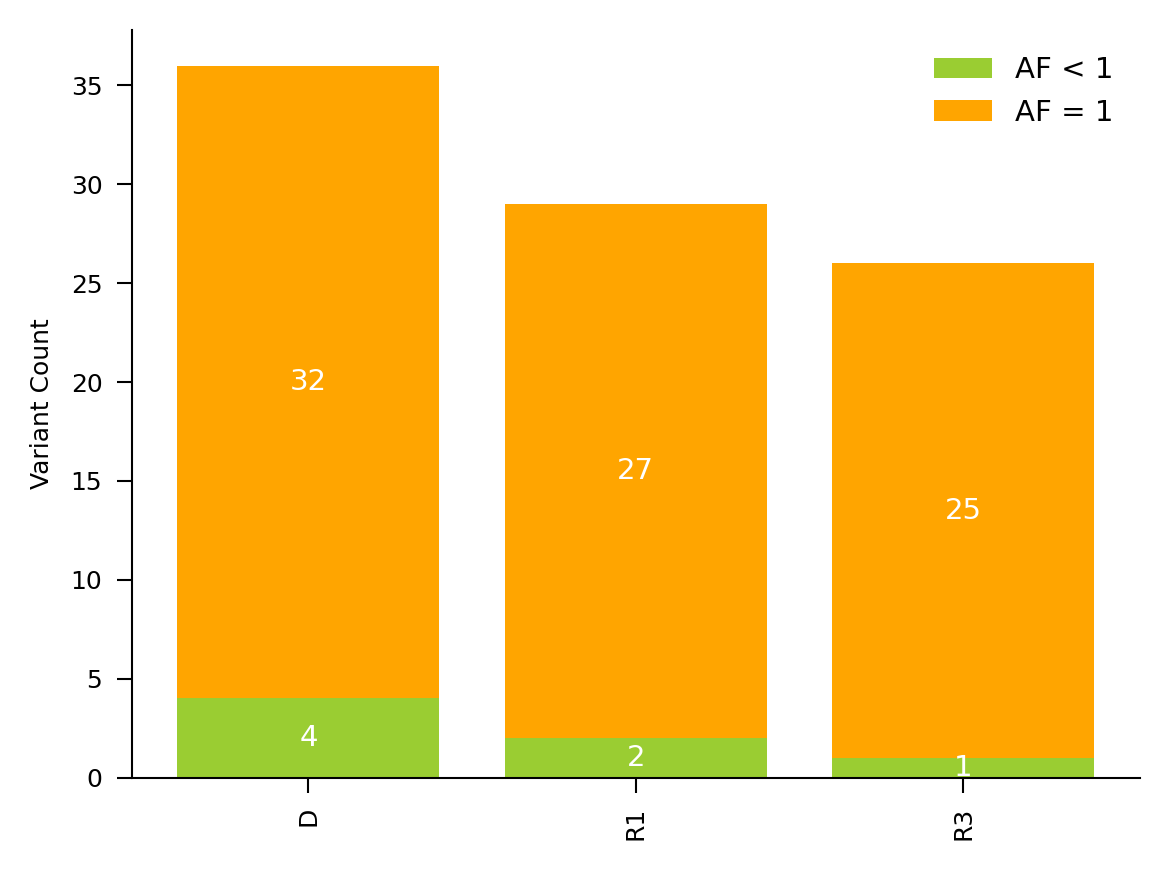

In [35]:
counts = (
    df_combined_complete_full_generation_wise
    .groupby(["pop", "AF_category"])
    .size()
    .reset_index(name="count")
)
# Pivot so AF_category values become columns
pivot_df = counts.pivot(index="pop", columns="AF_category", values="count").fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
bottom = None

colors = {"AF < 1": "yellowgreen", "AF = 1": "orange"}

for cat in pivot_df.columns:
    ax.bar(
        pivot_df.index,
        pivot_df[cat],
        bottom=bottom,
        label=cat,
        color=colors.get(cat, None)
    )
    # Add text labels
    for i, val in enumerate(pivot_df[cat]):
        y = val/2 if bottom is None else bottom[i] + val/2
        ax.text(i, y, f"{int(val)}", ha="center", va="center", fontsize=7, color="white")
    bottom = pivot_df[cat] if bottom is None else bottom + pivot_df[cat]

ax.set_ylabel("Variant Count")
ax.legend(frameon=False, fontsize=7)
ax = utility.custom_figure_axis(ax=ax, fontsize = 6)
plt.tight_layout()
plt.show()

In [49]:
# df_combined_unique_complete_full

##### Fig. 5c

/tmp/ipykernel_564437/1132029771.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = val/2 if bottom is None else bottom[i] + val/2


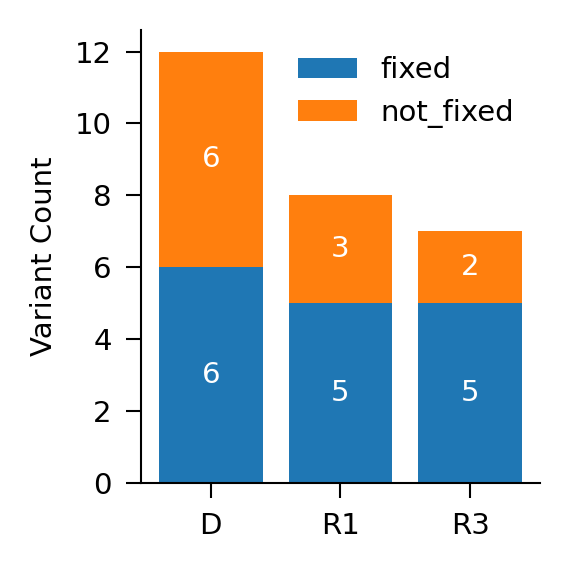

In [48]:
counts = (
    df_combined_unique_complete_full
    .groupby(["pop", "mutation_type"])
    .size()
    .reset_index(name="count")
)
# Pivot so AF_category values become columns
pivot_df = counts.pivot(index="pop", columns="mutation_type", values="count").fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
bottom = None

colors = {"AF < 1": "yellowgreen", "AF = 1": "orange"}

for cat in pivot_df.columns:
    ax.bar(
        pivot_df.index,
        pivot_df[cat],
        bottom=bottom,
        label=cat,
        color=colors.get(cat, None)
    )
    # Add text labels
    for i, val in enumerate(pivot_df[cat]):
        y = val/2 if bottom is None else bottom[i] + val/2
        ax.text(i, y, f"{int(val)}", ha="center", va="center", fontsize=7, color="white")
    bottom = pivot_df[cat] if bottom is None else bottom + pivot_df[cat]

ax.set_ylabel("Variant Count")
ax.legend(frameon=False, fontsize=7)
ax = utility.custom_figure_axis(ax=ax, fontsize = 7, rotation=0)
plt.tight_layout()
plt.savefig("Lab experiment fix vs non fix.pdf", dpi = 300)